# Validation of XENON1T Binwise likelihood implementation in DDCalc

See https://github.com/GambitBSM/DDCalc/pull/3 for code

In [1]:
import sys
import os
sys.path.append("/Users/kdund/Software/DDCalc/include/")
import DDCalcInclude
import DDCalc
import directdm as ddm

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy.interpolate import interp1d

In [2]:
def print_to_fortran(array, linewidth=80):
    template = "{:6e}"
    flat_array = (array.T).flatten()
    ret = [template.format(i).replace("e","d") for i in flat_array]
    numlen = len(ret[0]) + 1
    per_line = linewidth/numlen
    print("(/ &")
    line_splits = np.ceil(len(ret)/per_line)
    for i, rets in enumerate(np.array_split(ret, line_splits)):
        divider = ","
        if i>=line_splits-1:
            divider=""
        print(",".join(rets) + divider+ " &")
    print("/)")
    

###  Initialise Binwise XENON likelihood
Code from the DDCalc example

In [3]:
halo = DDCalc.InitHalo()	   # Initialise a DM Halo object to default values.

# Optionally set the Standard Halo Model parameters to values different from the default choices:
#       rho     Local dark matter density [GeV/cm^3]
#       vrot    Local disk rotation speed [km/s]
#       v0      Maxwell-Boltzmann most probable speed [km/s]
#       vesc    Galactic escape speed [km/s]
DDCalc.SetSHM(halo, 0.3, 235.0, 235.0, 550.0)
detector = DDCalc.InitExperiment('Xenon1T_2022')    # Initalize the XENON1T_2018 detector.
wimp = DDCalc.InitWIMP()


mDM = 50.0	 												# DM Mass in GeV                  
sigmap_SI = 1.0e-9											# SI WIMP-proton cross section, 1e-45cm2
sigman_SI = sigmap_SI											# SI WIMP-neutron cross section in pb.

DDCalc.SetWIMP_msigma(wimp, mDM, sigmap_SI, sigman_SI, 0, 0)
DDCalc.CalcRates(detector, wimp, halo) 	             # This performs the actual calculation of the rates.

DDCalc.Signal(detector) #returns 176, pretty correct



176.09889539907414

In [4]:
### Init XENON binwise inference

In [5]:
DDCalc.BindRdE(detector,5)

7.870044318351696e-05

In [6]:
from xe_likelihood import BinwiseInference, Spectrum

spectrum = Spectrum.from_wimp(mass=50)
inference = BinwiseInference.from_xenon1t_sr(spectrum=spectrum)
#example inference: inference.plot_summary(show=True)

## Load XENON binwise likelihood

In [7]:
migmat = inference.migration_matrix
likmat = inference.likelihood_matrix
Ne = len(migmat.x_bins)
Es = migmat.x_bins
NBmus = len(likmat.y_bins)
NBins = len(migmat.y_bins)
Mumax = likmat.y_bins[-1]



In [8]:

de = Es[1] - Es[0]
derec = (migmat.y_bins[1] - migmat.y_bins[0])
drde_from_DDCalc = np.array([DDCalc.BindRdE(detector, i+1) for i in range(Ne)])*1300*278.8 #rate /bin

In [9]:
signal_from_DDCalc = np.array([DDCalc.BinSignal(detector, i+1) for i in range(NBins)]) #reference signal at 1e-45cm2

In [10]:
signal_from_migmat = np.matmul(drde_from_DDCalc * de, migmat.zs["0"])

### Spectrum in detector coordinates

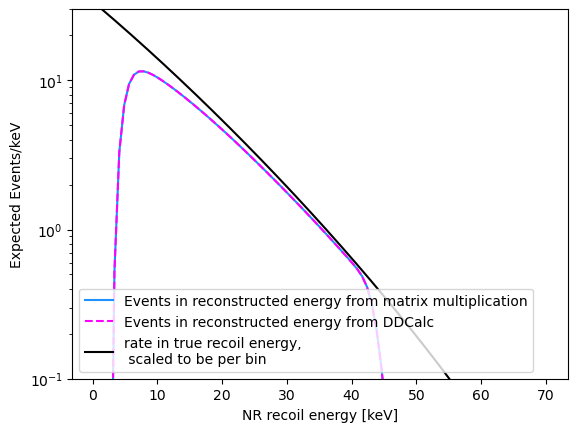

In [11]:
plt.clf()
plt.plot(migmat.y_bins,signal_from_migmat/derec,color="dodgerblue", label="Events in reconstructed energy from matrix multiplication")
plt.plot(migmat.y_bins,signal_from_DDCalc/derec,color="magenta", linestyle="--",label="Events in reconstructed energy from DDCalc")
plt.plot(migmat.x_bins,drde_from_DDCalc, color="k", label="rate in true recoil energy,\n scaled to be per bin")
plt.xlabel("NR recoil energy [keV]")
plt.ylabel("Expected Events/keV")
plt.yscale("log")
plt.legend()
plt.ylim(0.1,30)
plt.show()

#### Conclusion: the signal convolution agrees

### Likelihoods with DDCalc 

In [12]:
sigmas = np.linspace(0,1e-9,200) #up to 1e-45cm2
ll_ddcalc = np.zeros(len(sigmas))

detector = DDCalc.InitExperiment('Xenon1T_2022')    # Initalize the XENON1T_2018 detector.
wimp = DDCalc.InitWIMP()

for i, sigma in tqdm(enumerate(sigmas)):
    DDCalc.SetWIMP_msigma(wimp, mDM, sigma, sigma, 0, 0)
    DDCalc.CalcRates(detector, wimp, halo) 	     
    ll_ddcalc[i] = DDCalc.LogLikelihood(detector)

200it [00:00, 5147.36it/s]


### Likelihoods with tabulated likelihoods: 

In [13]:
L = likmat.zs["0"]

In [14]:
mus = likmat.y_bins
ll_binwise_nominal = np.zeros(len(sigmas))


for i in tqdm(range(NBins)):
    mubin = signal_from_DDCalc[i] * (sigmas / (1e-9))
    fcn = interp1d(mus, L[i,:], bounds_error=False, fill_value=np.inf) 
    ll_binwise_nominal += fcn(mubin)

100%|████████████████████████████████████████| 80/80 [00:00<00:00, 36018.07it/s]


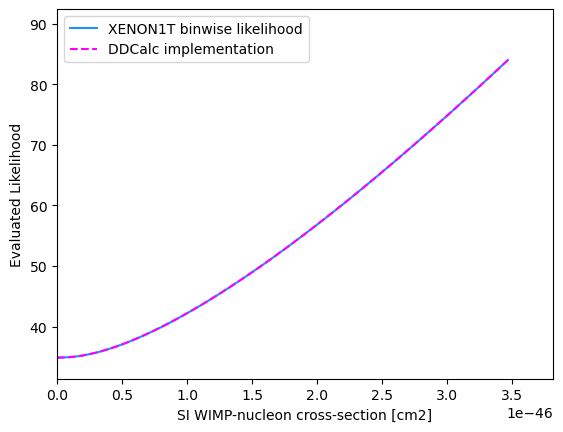

In [15]:
plt.clf()
mask1 = np.isfinite(ll_binwise_nominal)
mask2 = np.isfinite(ll_ddcalc)
ymin = 0.9*np.min(ll_binwise_nominal[mask1])
ymax = 1.1*np.max(ll_binwise_nominal[mask1])
xmax = np.max(sigmas[mask1])*1.1
plt.plot(sigmas[mask1]*1e-36, ll_binwise_nominal[mask1], color="dodgerblue", label="XENON1T binwise likelihood")
plt.plot(sigmas[mask2]*1e-36, ll_ddcalc[mask2], color="magenta", linestyle="--", label="DDCalc implementation")
plt.ylim(ymin, ymax)
plt.xlim(0,xmax*1e-36)
plt.legend()
plt.ylabel("Evaluated Likelihood")
plt.xlabel("SI WIMP-nucleon cross-section [cm2]")
plt.show()

#### Conclusion: The likelihood evaluation agrees 

## Print FORTRAN tables: 
(to put in the experiment file)

In [16]:

print("NE", Ne)
print("NBINS", NBins)
print("NBMUS", NBmus)
print("MUMAX", Mumax)

NE 277
NBINS 80
NBMUS 101
MUMAX 3.0


In [17]:
print("E(NE)")
print_to_fortran(migmat.x_bins)

E(NE)
(/ &
1.000000d+00,1.250000d+00,1.500000d+00,1.750000d+00,2.000000d+00,2.250000d+00,2.500000d+00, &
2.750000d+00,3.000000d+00,3.250000d+00,3.500000d+00,3.750000d+00,4.000000d+00, &
4.250000d+00,4.500000d+00,4.750000d+00,5.000000d+00,5.250000d+00,5.500000d+00, &
5.750000d+00,6.000000d+00,6.250000d+00,6.500000d+00,6.750000d+00,7.000000d+00, &
7.250000d+00,7.500000d+00,7.750000d+00,8.000000d+00,8.250000d+00,8.500000d+00, &
8.750000d+00,9.000000d+00,9.250000d+00,9.500000d+00,9.750000d+00,1.000000d+01, &
1.025000d+01,1.050000d+01,1.075000d+01,1.100000d+01,1.125000d+01,1.150000d+01, &
1.175000d+01,1.200000d+01,1.225000d+01,1.250000d+01,1.275000d+01,1.300000d+01, &
1.325000d+01,1.350000d+01,1.375000d+01,1.400000d+01,1.425000d+01,1.450000d+01, &
1.475000d+01,1.500000d+01,1.525000d+01,1.550000d+01,1.575000d+01,1.600000d+01, &
1.625000d+01,1.650000d+01,1.675000d+01,1.700000d+01,1.725000d+01,1.750000d+01, &
1.775000d+01,1.800000d+01,1.825000d+01,1.850000d+01,1.875000d+01,1.900000d+01, &
1.92

In [18]:
print("E(NE)")
print_to_fortran(migmat.x_bins)

E(NE)
(/ &
1.000000d+00,1.250000d+00,1.500000d+00,1.750000d+00,2.000000d+00,2.250000d+00,2.500000d+00, &
2.750000d+00,3.000000d+00,3.250000d+00,3.500000d+00,3.750000d+00,4.000000d+00, &
4.250000d+00,4.500000d+00,4.750000d+00,5.000000d+00,5.250000d+00,5.500000d+00, &
5.750000d+00,6.000000d+00,6.250000d+00,6.500000d+00,6.750000d+00,7.000000d+00, &
7.250000d+00,7.500000d+00,7.750000d+00,8.000000d+00,8.250000d+00,8.500000d+00, &
8.750000d+00,9.000000d+00,9.250000d+00,9.500000d+00,9.750000d+00,1.000000d+01, &
1.025000d+01,1.050000d+01,1.075000d+01,1.100000d+01,1.125000d+01,1.150000d+01, &
1.175000d+01,1.200000d+01,1.225000d+01,1.250000d+01,1.275000d+01,1.300000d+01, &
1.325000d+01,1.350000d+01,1.375000d+01,1.400000d+01,1.425000d+01,1.450000d+01, &
1.475000d+01,1.500000d+01,1.525000d+01,1.550000d+01,1.575000d+01,1.600000d+01, &
1.625000d+01,1.650000d+01,1.675000d+01,1.700000d+01,1.725000d+01,1.750000d+01, &
1.775000d+01,1.800000d+01,1.825000d+01,1.850000d+01,1.875000d+01,1.900000d+01, &
1.92

In [19]:
migmat_hist = migmat.zs['0']
migmat_sum = np.sum(migmat_hist,axis=1)
migmat_extended = np.zeros((migmat_hist.shape[0], migmat_hist.shape[1] +1 )) #DDCalc uses a 0th index row to store the sum of the migration matrix (i.e. the efficiency)
migmat_extended[:,0] = migmat_sum
migmat_extended[:,1::] = migmat_hist
print("EFF")
print_to_fortran(migmat_extended)

EFF
(/ &
5.000000d-05,3.100000d-04,1.170000d-03,3.180000d-03,7.150000d-03,1.382000d-02,2.390000d-02, &
3.811000d-02,5.654000d-02,7.886000d-02,1.054300d-01,1.355400d-01,1.682300d-01,2.037900d-01, &
2.412100d-01,2.795600d-01,3.169100d-01,3.542800d-01,3.898100d-01,4.263100d-01,4.595300d-01, &
4.923000d-01,5.223400d-01,5.507300d-01,5.767500d-01,6.001700d-01,6.236300d-01,6.436700d-01, &
6.633600d-01,6.796300d-01,6.951900d-01,7.094300d-01,7.220300d-01,7.348800d-01,7.444000d-01, &
7.543200d-01,7.632900d-01,7.697900d-01,7.776200d-01,7.845200d-01,7.913500d-01,7.969500d-01, &
8.007100d-01,8.054100d-01,8.103400d-01,8.129500d-01,8.186900d-01,8.225800d-01,8.239700d-01, &
8.277200d-01,8.298800d-01,8.323800d-01,8.345200d-01,8.368600d-01,8.394000d-01,8.406500d-01, &
8.429300d-01,8.451200d-01,8.454300d-01,8.476900d-01,8.494900d-01,8.509900d-01,8.506200d-01, &
8.510000d-01,8.529800d-01,8.540600d-01,8.548100d-01,8.549900d-01,8.557700d-01,8.561700d-01, &
8.577800d-01,8.575700d-01,8.596900d-01,8.588400d-01